# Modeling - Simple Regression with feature selection and regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from linearmodels.panel import PanelOLS
import os
import seaborn as sns
import statsmodels.api as sm
from itertools import product
from sklearn.linear_model import ElasticNet
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_pickle("feature_engineering_train_dataset.pkl")
df_valid = pd.read_pickle("feature_engineering_validation_dataset.pkl")

In [3]:
display(df_train.head(3))
print("Shape: ", df_train.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-01-12,10001,27.626437,29.695810,2.245193,61.460460,59.611104,28.867446,45.176114,37.305956,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-13,10001,29.008665,26.041461,2.355360,64.432266,56.863993,29.842478,45.557870,39.091765,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-14,10001,29.180034,26.490986,1.905282,68.381496,64.845904,34.533212,47.707745,37.870228,...,0,0,0,0,0,0,0,0,0,0


Shape:  (8038, 105)


In [4]:
display(df_valid.head(3))
print("Shape: ", df_valid.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-02-02,10001,32.242002,16.735176,3.854930,65.747872,67.494766,22.045415,66.438259,44.750377,...,0,0,0,0,0,0,0,0,0,0
1,2021-02-03,10001,34.991057,18.797872,9.298927,66.752089,64.805847,26.106294,63.255370,46.075447,...,0,0,0,0,0,0,0,0,0,0
2,2021-02-04,10001,31.996321,17.816678,8.826546,69.706913,64.414916,26.765270,63.628774,46.781418,...,0,0,0,0,0,0,0,0,0,0


Shape:  (1717, 105)


In [5]:
# Feature Selection: 
# Drop smoothed_wvaccine_likely_who since we already have smoothed_wvaccine_likely_govt_health
# Drop smoothed_wwearing_mask since we already have smoothed_wothers_masked 
# Drop smoothed_wcovid_vaccinated_or_accept since it states that espondents who either have already received a COVID vaccine or would definitely or probably choose to get vaccinated
list_drop_cols = ['smoothed_wvaccine_likely_who','smoothed_wwearing_mask','smoothed_wcovid_vaccinated_or_accept'
                  ,'smoothed_wvaccine_likely_who_rolling_mean_3','smoothed_wwearing_mask_rolling_mean_3','smoothed_wcovid_vaccinated_or_accept_rolling_mean_3'
                  ,'smoothed_wvaccine_likely_who_lag_3','smoothed_wwearing_mask_lag_3','smoothed_wcovid_vaccinated_or_accept_lag_3'
                  ]

In [6]:
df_train = df_train.drop(columns = list_drop_cols)
df_valid = df_valid.drop(columns = list_drop_cols)

In [7]:
print("Shape: ", df_train.shape)
print("Shape: ", df_valid.shape)

Shape:  (8038, 96)
Shape:  (1717, 96)


In [8]:
target_var = 'smoothed_wcovid_vaccinated'
list_features = [col for col in df_train.columns if col not in ["time_value",'geo_value','state','county_name'
                                                                ,'day_of_week','day','week_of_month','State'
                                                                ,'County Name','day_of_week'
                                                                ,target_var]]

In [9]:
list_scale = [col for col in list_features if 'dummy' not in col]
list_scale[-5:]

['smoothed_wcli_lag_3_x_smoothed_wwork_outside_home_1d',
 'smoothed_wothers_masked_x_smoothed_wcovid_vaccinated_or_accept',
 'smoothed_wtested_14d_x_smoothed_wvaccine_likely_govt_health',
 'smoothed_wcli_x_smoothed_wcovid_vaccinated_or_accept',
 'smoothed_wcovid_vaccinated_or_accept_x_smoothed_wvaccine_likely_friends']

In [10]:
x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(df_train[list_scale])
df_train[list_scale] = X_train_scaled

X_valid_scaled = x_scaler.transform(df_valid[list_scale])
df_valid[list_scale] = X_valid_scaled

with open("x_scaler_for_regression_model_experiment_01.pkl", "wb") as f:
    pickle.dump(x_scaler, f)

In [11]:
display(df_train.head(3))
display(df_valid.head(3))

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-01-12,10001,-0.512719,3.453118,-0.232835,-1.779211,-0.446448,-1.470753,0.889560,1.116949,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-13,10001,-0.241877,2.673870,-0.194110,-2.295394,-0.292681,-1.381493,1.232369,1.079239,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-14,10001,-0.208298,2.769726,-0.352316,-0.795589,0.447070,-0.878818,0.997879,1.172630,...,0,0,0,0,0,0,0,0,0,0


,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-02-02,10001,0.391681,0.689412,0.333000,-0.297866,-1.522314,3.500675,2.318613,0.828525,...,0,0,0,0,0,0,0,0,0,0
1,2021-02-03,10001,0.930347,1.129258,2.246608,-0.803116,-0.881895,2.756464,2.572978,0.384049,...,0,0,0,0,0,0,0,0,0,0
2,2021-02-04,10001,0.343541,0.920030,2.080563,-0.876572,-0.777971,2.843772,2.708498,0.359766,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_train_original = df_train[target_var]
y_valid_original = df_valid[target_var]

In [13]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(df_train[[target_var]])
df_train[target_var] = y_train_scaled

y_valid_scaled = y_scaler.transform(df_valid[[target_var]])
df_valid[target_var] = y_valid_scaled
with open("y_scaler_for_regression_model_experiment_01.pkl", "wb") as f:
    pickle.dump(y_scaler, f)

In [14]:
list_time_value = sorted(df_train['time_value'].unique())
list_time_value

[Timestamp('2021-01-10 00:00:00'),
 Timestamp('2021-01-11 00:00:00'),
 Timestamp('2021-01-12 00:00:00'),
 Timestamp('2021-01-13 00:00:00'),
 Timestamp('2021-01-14 00:00:00'),
 Timestamp('2021-01-15 00:00:00'),
 Timestamp('2021-01-16 00:00:00'),
 Timestamp('2021-01-17 00:00:00'),
 Timestamp('2021-01-18 00:00:00'),
 Timestamp('2021-01-19 00:00:00'),
 Timestamp('2021-01-20 00:00:00'),
 Timestamp('2021-01-21 00:00:00'),
 Timestamp('2021-01-22 00:00:00'),
 Timestamp('2021-01-23 00:00:00'),
 Timestamp('2021-01-24 00:00:00'),
 Timestamp('2021-01-25 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-27 00:00:00'),
 Timestamp('2021-01-28 00:00:00'),
 Timestamp('2021-01-29 00:00:00')]

In [15]:
tscv = TimeSeriesSplit(n_splits=3, test_size=3)
for i, (train_index, valid_index) in enumerate(tscv.split(list_time_value)):
    print(f"Fold {i}:")
    print(f"  Train Data    : First Date = {list_time_value[train_index[0]]}, Last Date = {list_time_value[train_index[-1]]}")
    print(f"  Train Shape   :", df_train[(df_train['time_value']>=list_time_value[train_index[0]])&(df_train['time_value']<=list_time_value[train_index[-1]])].shape)
    print(f"  Validation Data     : First Date = {list_time_value[valid_index[0]]}, Last Date = {list_time_value[valid_index[-1]]}")
    print(f"  Validation Shape    :", df_train[(df_train['time_value']>=list_time_value[valid_index[0]])&(df_train['time_value']<=list_time_value[valid_index[-1]])].shape)

Fold 0:
  Train Data    : First Date = 2021-01-10 00:00:00, Last Date = 2021-01-20 00:00:00
  Train Shape   : (4105, 96)
  Validation Data     : First Date = 2021-01-21 00:00:00, Last Date = 2021-01-23 00:00:00
  Validation Shape    : (1311, 96)
Fold 1:
  Train Data    : First Date = 2021-01-10 00:00:00, Last Date = 2021-01-23 00:00:00
  Train Shape   : (5416, 96)
  Validation Data     : First Date = 2021-01-24 00:00:00, Last Date = 2021-01-26 00:00:00
  Validation Shape    : (1311, 96)
Fold 2:
  Train Data    : First Date = 2021-01-10 00:00:00, Last Date = 2021-01-26 00:00:00
  Train Shape   : (6727, 96)
  Validation Data     : First Date = 2021-01-27 00:00:00, Last Date = 2021-01-29 00:00:00
  Validation Shape    : (1311, 96)


In [16]:
list_all_faeture = list_features.copy()
list_all_faeture.append("constant")
df_train['constant'] = 1.0
df_valid['constant'] = 1.0

In [17]:
list_alpha = [0.01, 0.1, 1.0, 10]
list_l1_ratio = [0.1, 0.5, 0.9]
results = []
combinations = list(product(list_alpha, list_l1_ratio))

# Loop over alpha-l1_ratio pairs
for alpha, l1_ratio in combinations:
    rmse_folds = []

    # Loop over time-based folds
    for train_index, valid_index in tscv.split(list_time_value):
        start_train = list_time_value[train_index[0]]
        end_train = list_time_value[train_index[-1]]
        start_valid = list_time_value[valid_index[0]]
        end_valid = list_time_value[valid_index[-1]]

        # Filter train and validation sets by date
        df_train_fold = df_train[(df_train['time_value'] >= start_train) & (df_train['time_value'] <= end_train)]
        df_valid_fold = df_train[(df_train['time_value'] >= start_valid) & (df_train['time_value'] <= end_valid)]

        # Train model
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=88)
        model.fit(df_train_fold[list_all_faeture], df_train_fold[target_var])

        # Predict and calculate RMSE
        y_pred = model.predict(df_valid_fold[list_all_faeture])
        rmse = root_mean_squared_error(df_valid_fold[target_var], y_pred)
        rmse_folds.append(rmse)

    # Store average RMSE across all folds
    results.append({
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'avg_RMSE': np.mean(rmse_folds)
    })

# Create results DataFrame
df_results = pd.DataFrame(results).sort_values('avg_RMSE').reset_index(drop=True)

In [18]:
best_row = df_results.loc[df_results['avg_RMSE'].idxmin()]
best_alpha = best_row['alpha']
best_l1_ratio = best_row['l1_ratio']

print(f"Best alpha: {best_alpha}, Best l1_ratio: {best_l1_ratio}")

Best alpha: 0.01, Best l1_ratio: 0.1


In [19]:
best_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=88)
best_model.fit(df_train[list_all_faeture], df_train[target_var])

ElasticNet(alpha=np.float64(0.01), l1_ratio=np.float64(0.1), random_state=88)

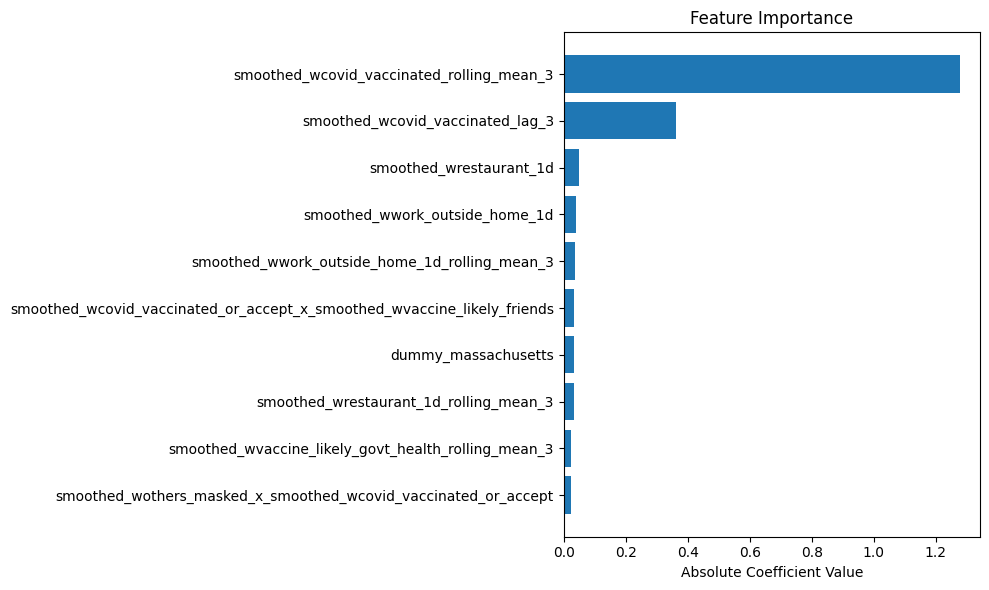

In [20]:
coef_df = pd.DataFrame({
    'Feature': list_all_faeture,
    'Coefficient': best_model.coef_
})

coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoef', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df.head(10)['Feature'], coef_df.head(10)['AbsCoef'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [21]:
with open('regression_model_experiment_01.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [22]:
y_train_pred_scaler = best_model.predict(df_train[list_all_faeture])
y_train_pred_scaler

array([-1.00123091, -1.09370931, -1.07992149, ...,  0.75940695,
        0.91708094,  0.98203082])

In [23]:
y_train_pred_original = y_scaler.inverse_transform(y_train_pred_scaler.reshape(-1, 1)).ravel()
y_train_pred_original

array([ 6.34595208,  5.94484145,  6.00464397, ..., 13.98244439,
       14.66633075, 14.94804074])

In [24]:
train_rmse = root_mean_squared_error(y_train_original, y_train_pred_original)

print(f"Train RMSE: {train_rmse:.4f}")

Train RMSE: 1.2256


In [25]:
y_valid_pred_scaler = best_model.predict(df_valid[list_all_faeture])
y_valid_pred_scaler

array([2.81713613, 2.48041662, 2.21036456, ..., 0.63354864, 0.61440042,
       0.99621551])

In [26]:
y_valid_pred_original = y_scaler.inverse_transform(y_valid_pred_scaler.reshape(-1, 1)).ravel()
y_valid_pred_original

array([22.90752395, 21.4470556 , 20.27574688, ..., 13.43655358,
       13.35350116, 15.00956461])

In [27]:
valid_rmse = root_mean_squared_error(y_valid_original, y_valid_pred_original)

print(f"Validation RMSE: {valid_rmse:.4f}")

Validation RMSE: 1.5621


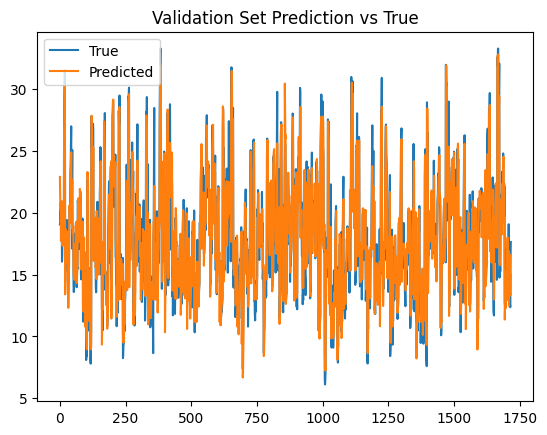

In [28]:
plt.plot(y_valid_original, label="True")
plt.plot(y_valid_pred_original, label="Predicted")
plt.title("Validation Set Prediction vs True")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Residual Distribution')

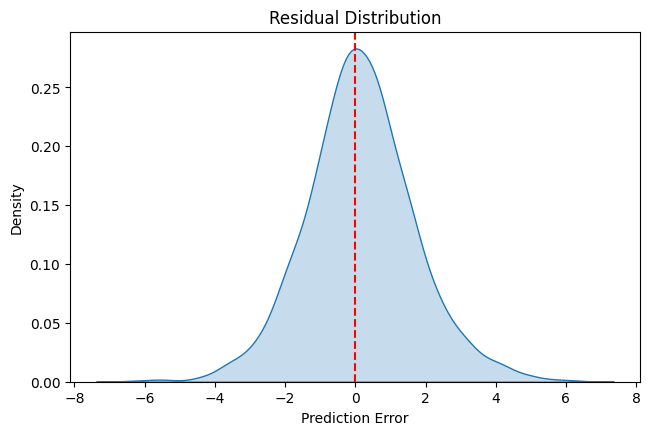

In [29]:
plt.figure(figsize=(25, 10))
plt.subplot(234)
sns.kdeplot(y_valid_original - y_valid_pred_original, label='Residual', fill=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Residual Distribution')